<h1 class="text_center">Project description</h1><br>
The Sure Tomorrow insurance company wants to protect its clients' data. My task is to develop a data transforming algorithm that would make it hard to recover personal information from the transformed data. This is called data masking, or data obfuscation. I am also expected to prove that the algorithm works correctly. Additionally, the data should be protected in such a way that the quality of machine learning models doesn't suffer.

- construct a theoretical proof using properties of models and the given task;
- formulate an algorithm for this proof;
- check that the algorithm is working correctly when applied to real data.

I will use a simple method of data masking, based on an invertible matrix.

<h3 class="text_center">Data description</h3>

**Features**: insured person's gender, age, salary, and number of family members.<br>
**Target**: number of insurance benefits received by the insured person over the last five years.

<h3 class="text_center">Download and look into the data.</h3>

In [1]:
import pandas as pd
import numpy as np
import scipy

import time
from tqdm import tnrange
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('./insurance_us.csv')
data

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


<h3 class="text_center">Provide a theoretical proof based on the equation of linear regression. The features are multiplied by an invertible matrix. Show that the quality of the model is the same for both sets of parameters: the original features and the features after multiplication. How are the weight vectors from MSE minimums for these models related?</h3>

$$MSE(X\cdot w_2, y) == MSE(X\cdot A\cdot w_1, y)$$ 

where A - is invertible matrix

$$w_1 = ((XA)^T\cdot XA)^{-1}\cdot(XA)^T\cdot y$$
$$w_2 = ((X)^T\cdot X)^{-1}\cdot(X)^T\cdot y$$

$$\sum_{i=1}^{n}((XA\cdot ((XA)^T\cdot XA)^{-1}\cdot (XA)^T\cdot y)_i - y_i)^2 = \sum_{i=1}^{n}((X\cdot (X^T\cdot X)^{-1}\cdot X^T\cdot y)_i - y_i)^2$$

based on these two simple properties of matrices:

$$(A⋅B)^{−1}=B^{−1}⋅A^{−1}$$
$$(A⋅B)^T=B^T⋅A^T$$

the left part of the expression is reduced to a ones matrix:

$$XA\cdot ((XA)^T\cdot XA)^{-1}\cdot (XA)^T = XA\cdot (A^T\cdot (X^TX)\cdot A)^{-1}\cdot (XA)^T = XA\cdot A^{-1}\cdot (X^TX)^{-1}\cdot (A^T)^{-1}\cdot A^TX^T = \\ = X\cdot(X^TX)^{-1}\cdot X^T$$

the right side is similarly transformed into a ones matrix too.

<div style="position: absolute; right: 200px; bottom: 15px; display: flex; align-items: center">
    <div style="width: 20px; height: 20px; background: black">
</div>




<h3 class="text_center">State an algorithm for data transformation to solve the task. Explanation, why the linear regression quality won't change based on the proof above.</h3>

Train two models:
- on the objects with untransformed features
- on the objects with transformed features, multiplied on invertible matrix

Make predictions on our own objects and compare two models trained on two different data. We approve above, that accuracy of the models will be the same. Let's check it in practice.


In [18]:
features = data.drop('Insurance benefits', 1)
target = data['Insurance benefits']

In [ ]:
model_first = LinearRegression()
model_first.fit(features, target)
predicted_value = model_first.predict(features)
score_first = r2_score(target, predicted_value)

print(score_first)

In [ ]:
model_first.coef_

In [5]:
results = []

for i in tnrange(1, 20):
    counter = 0
    det = 1
    while det != 0:
        invertible_matrix = np.random.randint(low=0,high=i,size=(4,4))
        det = np.linalg.det(invertible_matrix)
        counter += 1
    results.append(counter)
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0.98, 'Dependence of the range of values on the first attempt to obtain a non-degenerate matrix')

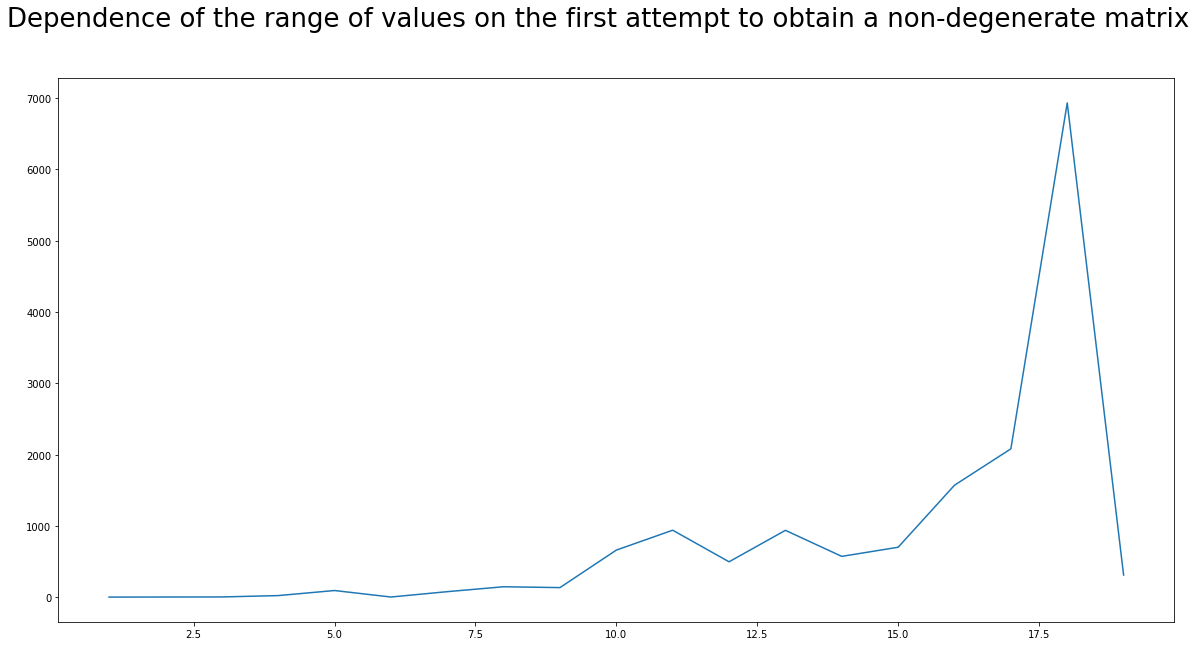

In [6]:
fig = plt.figure(figsize=(20,10))
plt.plot(np.arange(1, 20), results)
fig.suptitle('Dependence of the range of values on the first attempt to obtain a non-degenerate matrix', fontsize=26)


In [8]:
while True:
    invertible_matrix = np.random.randint(low=0,high=20,size=(4,4))
    det = np.linalg.det(invertible_matrix)
    
    if det != 0:
        break
        
print(invertible_matrix)

[[ 1 17  9 15]
 [ 8  4 16 16]
 [ 6 19  5  2]
 [ 7  0  7  7]]


In [200]:
features_invertible = features @ invertible_matrix

In [201]:
model = LinearRegression()
model.fit(features_invertible, target)
predicted_value = model.predict(features_invertible)
score = r2_score(target, predicted_value)

print(score)

0.42494550286668853


In [213]:
model.coef_

array([-0.00353878, -0.00083862, -0.0003337 ,  0.00498073])

We need to make sure that the quality of linear regression from sklearn is the same before and after transformation. We will use the R2 metric.

Below I show, that differs of scores is low and our theorem is true.

In [216]:
diff_between_scores = score_first - score
diff_between_scores

-8.43769498715119e-15

Accordingly, the difference between the weights vector of the first and second algorithms differs by the inverse matrix that we multiplied our features for
hiding their real values.


In [208]:
invertible_matrix @ model.coef_

array([ 7.92580543e-03,  3.57083050e-02, -1.70080491e-07, -1.35676623e-02])

In [214]:
model_first.coef_

array([ 7.92580543e-03,  3.57083050e-02, -1.70080492e-07, -1.35676623e-02])